In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from piecewise import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Settings

In [2]:
NP_DTYPE = np.float32

## Testing

In [3]:
tf.enable_eager_execution()

In [4]:
test = PiecewiseLinear(6,3,5)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                255       
_________________________________________________________________
reshape (Reshape)            (None, 3, 5)              0         
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


In [5]:
val = np.array(np.random.rand(1000000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))

True


In [6]:
np.allclose(test.forward_log_det_jacobian(val,event_ndims=1),-test.inverse_log_det_jacobian(forward,event_ndims=1))

False

In [7]:
test = PiecewiseQuadratic(6,3,5)

In [8]:
val = np.array(np.random.rand(1000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))
print(((val-inverse.numpy())/val)[np.logical_not(np.isclose(val,inverse.numpy()))])

True
[]


## Training

In [5]:
tf.disable_eager_execution()

In [3]:
sess = tf.InteractiveSession()

In [25]:
bijectors = []

for i in range(4):
    bijectors.append(PiecewiseLinear(2,1,32,layer_id=i))
#    bijectors.append(tfb.RealNVP(num_masked=1,
#                                 shift_and_log_scale_fn=tfb.real_nvp_default_template(
#                                     hidden_layers=[512,512])))
    bijectors.append(tfb.Permute(permutation=[1,0]))

# Discard the last Permute layer
test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
test_bijector.forward_min_event_ndims

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_25 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_26 (Dense)             (None, 32)                544       
_________________________________________________________________
reshape_8 (Reshape)          (None, 1, 32)             0         
Total params: 848
Trainable params: 848
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (In

1

In [26]:
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
base_dist = tfd.Independent(distribution=base_dist,
                           reinterpreted_batch_ndims=1,
                           )
#base_dist = tfd.MultivariateNormalDiag(loc=[0., 0.])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector,
)

base_dist

<tfp.distributions.Independent 'IndependentUniform_1/' batch_shape=() event_shape=(2,) dtype=float32>

In [27]:
x = base_dist.sample(5000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

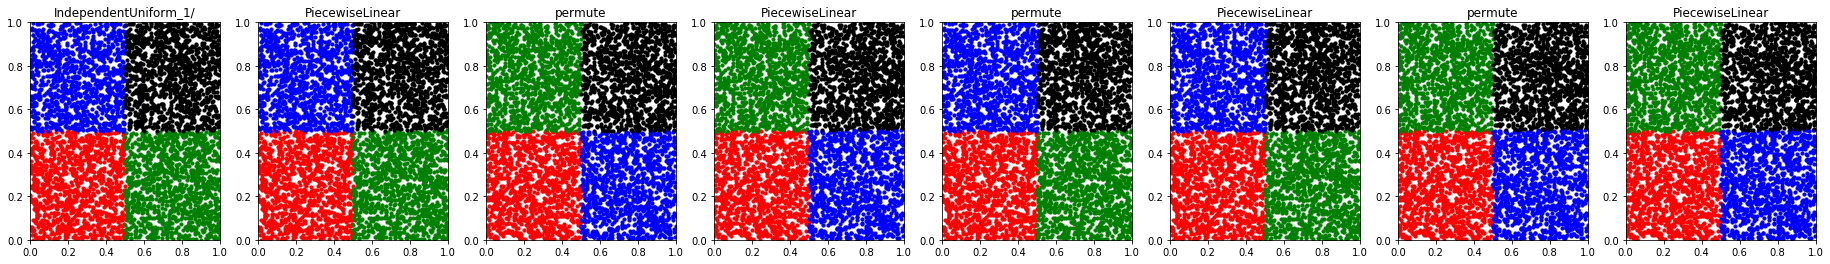

In [61]:
sess.run(tf.global_variables_initializer())
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [29]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[array([[-0.31166482,  0.27132088,  0.46178126, -0.26914808,  0.4938892 ,
        -0.10856345, -0.25928798, -0.34518874, -0.38098344,  0.1013577 ,
         0.16084045, -0.24973267,  0.32278693, -0.05730063,  0.27618128,
        -0.48274767]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([[-3.50351870e-01,  7.78544843e-02,  3.30220491e-01,
         3.09158772e-01, -4.03553247e-04, -6.16695881e-02,
        -1.80078417e-01,  2.99180299e-01,  2.65949041e-01,
        -2.95752555e-01,  2.48818606e-01, -8.45161080e-02,
         1.39449209e-01, -3.63071561e-02, -2.36127704e-01,
        -2.54405946e-01],
       [-1.68670893e-01,  2.05778033e-01, -3.89570653e-01,
         1.73369259e-01,  1.74966544e-01, -2.67917037e-01,
         3.98845166e-01,  2.96405524e-01,  3.31231862e-01,
        -2.01387003e-01, -3.75337392e-01, -3.55016589e-01,
        -9.07227099e-02,  6.59905076e-02,  2.35977203e-01,
         8.28559101e-02],
     

[array([[ 0.5679556 ,  0.56255627,  0.01282185, -0.1259239 , -0.36142057,
        -0.03055793, -0.4068842 ,  0.1159243 ,  0.32878762, -0.20606509,
         0.08324569,  0.5660646 ,  0.33239478,  0.585521  ,  0.44475555,
        -0.343442  ]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([[-0.2964067 , -0.3464659 , -0.2623104 , -0.2785071 , -0.0520359 ,
         0.26877478,  0.1037977 , -0.15526271, -0.11845538,  0.14810285,
         0.14861736, -0.25257933, -0.06962708,  0.1299927 , -0.13668737,
        -0.25166404],
       [ 0.40515175, -0.34970188,  0.09012166, -0.07176951, -0.31319147,
        -0.25525075,  0.23888776, -0.2846688 , -0.03461218, -0.14767069,
        -0.29517162,  0.33587655,  0.3246365 , -0.16057473, -0.41910723,
         0.12572572],
       [ 0.26233187, -0.34855914,  0.10988215, -0.27773675,  0.3255717 ,
         0.01975164,  0.22826931,  0.21779457, -0.03841528, -0.31496632,
        -0.26441944

In [92]:
def step(x,x0,k=50):
    return (1/2+1/2*tf.tanh(k*(x0-x)))

def dsigmaTrain(x):
    #return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))
    return (x[:,0]**2+x[:,1]**2)/((1-x[:,0])*(1-x[:,1]))*step(x[:,0],0.9)*step(x[:,1],0.9)

def dsigmaCircle(x):
    return (x[:,0]**2+x[:,1]**2)/((1-x[:,0])*(1-x[:,1]))*step(tf.sqrt(x[:,0]**2+x[:,1]**2),0.9)

def dsigmaTrue(x):
    return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))

def dsigmaTest(x):
    return 10**7*(1+(2*x[:,0]-1)**2)/((90**2-(90*2*(1-x[:,1]))**2)**2+2.5**2*90**2)

def normalChristina(x):
    return 0.8* tf.exp((-0.5*((x[:,0]-0.5)* (50 *(x[:,0]-0.5) -  15* (x[:,1]-0.5)) + (-15*(x[:,0]-0.5) + 5*(x[:,1]-0.5))* (x[:,1]-0.5))))
def normalChristina_np(x1,x2):
    return 0.8* np.exp((-0.5*((x1-0.5)* (50 *(x1-0.5) -  15* (x2-0.5)) + (-15*(x1-0.5) + 5*(x2-0.5))* (x2-0.5))))

In [93]:
x = dist.sample(5000)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = dsigmaCircle(x)

xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])

ValueError: autodetected range of [nan, nan] is not finite

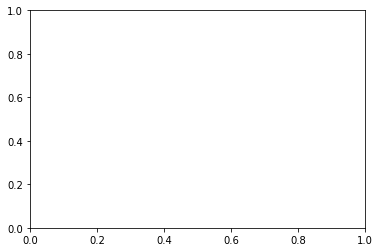

In [94]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts/qPts,norm=mpl.colors.LogNorm())
plt.show()

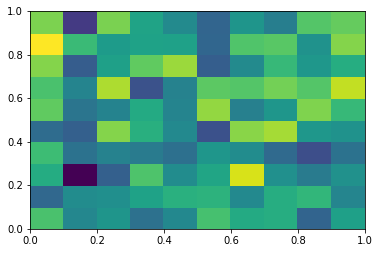

In [72]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=qPts,norm=mpl.colors.LogNorm())
plt.show()

In [73]:
loss = -sess.run(tf.reduce_mean(X))
print(loss)

-0.0037649078


In [74]:
def loss_fn(func):
    x = dist.sample(500)
    logq = dist.log_prob(x)
    p = func(x)
    q = dist.prob(x)
    p = p/tf.reduce_mean(p/q)
    return tf.reduce_mean(p/q*(tf.log(p)-logq))

In [335]:
def loss_fn2():
    x = dist.sample(10000)
    q = tf.exp(dist.log_prob(x))
    p = dsigmaTrain(x)
    return tf.reduce_mean(p*p/q)

In [78]:
def loss_fn3():
    x = dist.sample(500)
    logq = dist.log_prob(x)
    q = dist.prob(x)
    p = normalChristina(x)
    return tf.reduce_mean(p/q*(tf.log(p)-logq)) + tf.reduce_mean(tf.square((p-q)/q))

In [337]:
def grad():
    with tf.GradientTape() as tape:
        loss_value = loss_fn()
    return loss_value, tape.gradient(loss_value, bijector.trainable_variables)

In [58]:
def loss_grad():
    with tf.GradientTape() as tape:
        x = dist.sample(1000)
        logq = dist.log_prob(x)
        p = dsigmaTest(x)
        q = tf.stop_gradient(tf.exp(logq))
        loss = tf.reduce_mean(p/q*(tf.log(p)-logq))
    grad = tape.gradient(loss,bijector.trainable_variables)
    return loss, grad

In [75]:
loss = loss_fn(dsigmaCircle)
optimizer = tf.train.AdamOptimizer(1e-4)
grads = optimizer.compute_gradients(loss)
opt_op = optimizer.apply_gradients(grads)
sess.run(tf.global_variables_initializer())

nan


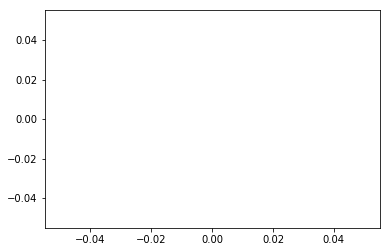

In [76]:
np_losses = []
global_step = []
for epoch in range(20000):
    _, np_loss = sess.run([opt_op, loss])
    global_step.append(epoch)
    np_losses.append(np_loss)
    #print(np_x,np_logq)
    if(np_loss != np_loss):
        print(np_loss)
        break
    if epoch % 500 == 0:
        print(epoch, np_loss)
        
start = 0
plt.plot(np_losses[start:])

In [42]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[array([[ 0.4138918 ,  0.23755085, -0.2307264 , -0.3539871 ,  0.3875106 ,
         0.00211948, -0.42850694, -0.5081028 , -0.2692192 ,  0.5617506 ,
        -0.26589724,  0.40837908,  0.0174933 , -0.48276198,  0.01906237,
        -0.2812876 ]], dtype=float32), array([ 0.28688034,  0.36145806,  0.19362909,  0.        , -0.07371848,
        0.32855064,  0.        ,  0.        ,  0.        ,  0.11135949,
        0.        ,  0.05535876,  0.3024638 ,  0.        , -0.01950316,
        0.        ], dtype=float32), array([[ 0.29722944,  0.29938668, -0.09552271, -0.07947996, -0.04039628,
         0.29364434, -0.07943932, -0.02866381,  0.07269302, -0.41806987,
         0.3664716 ,  0.3989121 ,  0.38885507,  0.11333502, -0.33598143,
         0.44015053],
       [ 0.14819415,  0.04843409,  0.0759851 , -0.41061303,  0.24715553,
         0.1422796 , -0.38570088,  0.5386903 ,  0.22689278,  0.08970496,
        -0.11905682, -0.19671382,  0.25004426,  0.6272261 , -0.34361216,
         0.21227455],
      

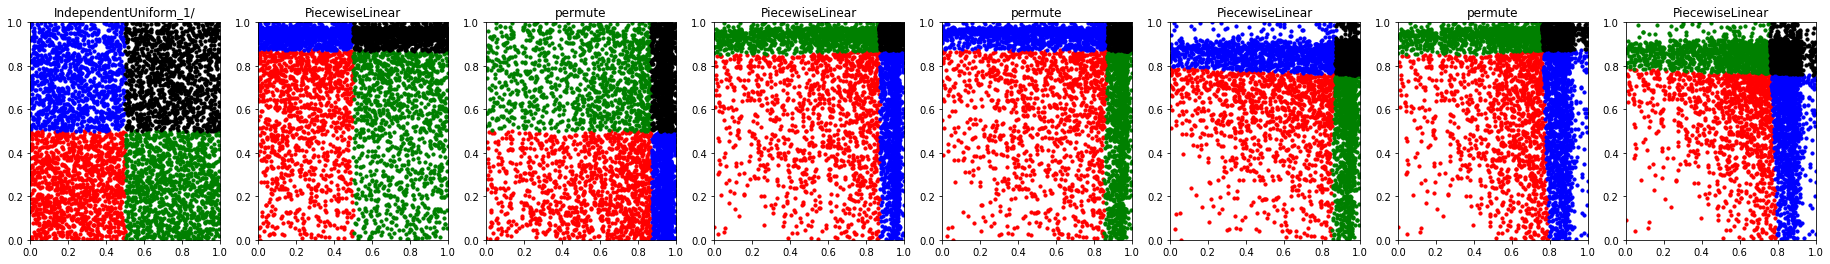

In [43]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

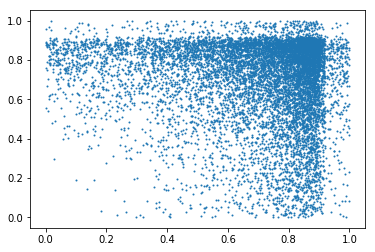

In [44]:
nsamples = 10000
x = dist.sample(nsamples)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = dsigmaTrue(x)

xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])

plt.scatter(xPts[:,0],xPts[:,1],s=1)
plt.show()

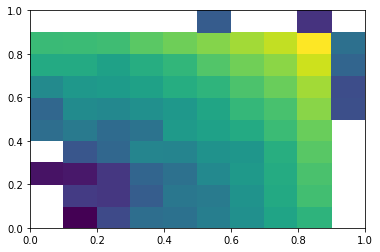

In [45]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts/qPts,norm=mpl.colors.LogNorm())
plt.show()

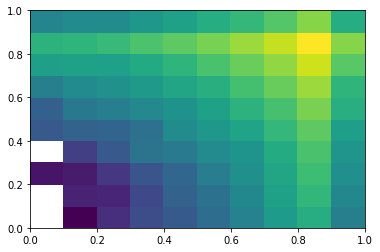

In [46]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=qPts,norm=mpl.colors.LogNorm())
plt.show()

In [47]:
def dsigma_np(x1,x2):
    return (x1**2 + x2**2)/((1-x1)*(1-x2))

def dsigmaTest_np(x1,x2):
    return (1+(2*x1-1)**2)/((90**2-(90*2*(1-x2))**2)**2+2.5**2*90**2)

In [48]:
import scipy.integrate as integrate

print(integrate.dblquad(dsigma_np,0.0,0.9,0.0,0.9))

(4.594049128242379, 3.1928194812308724e-07)


In [49]:
mean, var = sess.run(tf.nn.moments(dsig/q,axes=[0]))
print('xsec = %e, var = %e, stddev = %e' % (mean,var/nsamples,np.sqrt(var/nsamples)))

xsec = 4.574527e+00, var = 4.494094e-04, stddev = 2.119928e-02


In [50]:
x1 = tf.linspace(0.0,1,100)
x2 = tf.linspace(0.0,1,100)
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=0)),(10000,2))
Y = dist.cdf(x)
Z = dist.prob(x)

grid, cdf, pdf = sess.run([x,Y,Z])

/home/isaacson/Programs/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


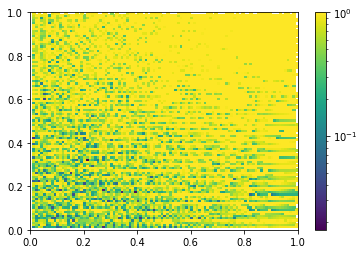

In [51]:
h = plt.hist2d(grid[:,0],grid[:,1],weights=cdf,norm=mpl.colors.LogNorm(),bins=100)
plt.colorbar(h[3])
plt.show()

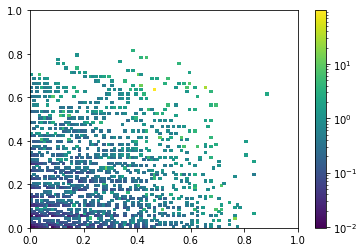

In [52]:
h = plt.hist2d(grid[:,0],grid[:,1],weights=pdf,norm=mpl.colors.LogNorm(),bins=100)
plt.colorbar(h[3])
plt.show()

In [70]:
x = tf.constant([0.8,0.2],shape=(1,2))
Y = dist.cdf(x)
sess.run([x,Y])

[array([[0.8, 0.2]], dtype=float32), array([0.8364656], dtype=float32)]

In [71]:
x = tf.constant([1.0,1.0],shape=(1,2))
Y = dist.cdf(x)
sess.run([x,Y])

[array([[1., 1.]], dtype=float32), array([nan], dtype=float32)]

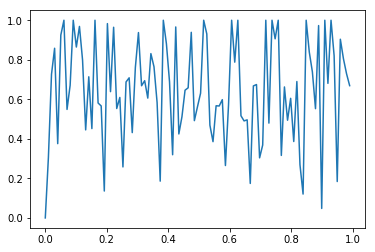

In [72]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.1])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

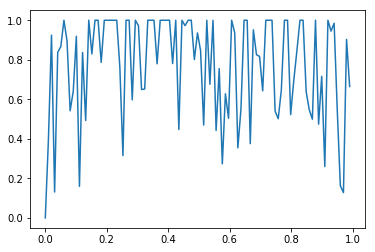

In [73]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.3])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

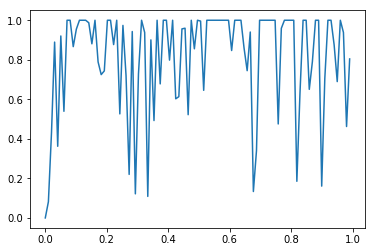

In [74]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.5])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

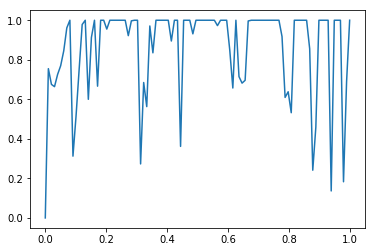

In [75]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.7])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

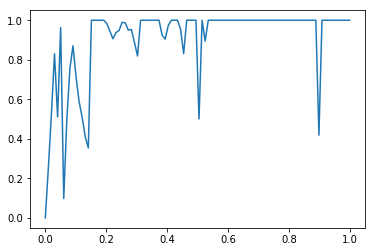

In [76]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.9])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()